In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap

%matplotlib inline


df = pd.read_excel(r"C:\Users\User\Downloads\WATER INJECTION DATA.xlsx")

df.head()

,Month/year,"Working hours, h","Injection volume, m3","Well downtime, h",Injectivity rate (m³/day)
0,2018-12-01,744,6241,0,201.32
1,2018-11-01,720,6769,0,225.63
2,2018-10-01,72,711,672,237.00
3,2018-09-01,362,6562,358,435.05
4,2018-08-01,170,2945,574,415.76


# Step 1

## Zaman sütununu tarix formatına veririb index əlavə edirik.

In [6]:
df['Month/year'] = pd.to_datetime(df['Month/year'])
df=df.sort_values('Month/year')
df.set_index('Month/year',inplace=True)

,Month/year,"Working hours, h","Injection volume, m3","Well downtime, h",Injectivity rate (m³/day)
0,2018-12-01,744,6241,0,201.32
1,2018-11-01,720,6769,0,225.63
2,2018-10-01,72,711,672,237.00
3,2018-09-01,362,6562,358,435.05
4,2018-08-01,170,2945,574,415.76


## Sütun adlarından boşluqları silirik

In [16]:
df.columns =[ col.strip() for col in df.columns]

## Zamanın vizaullaşdırılması ( Time-series plotting)

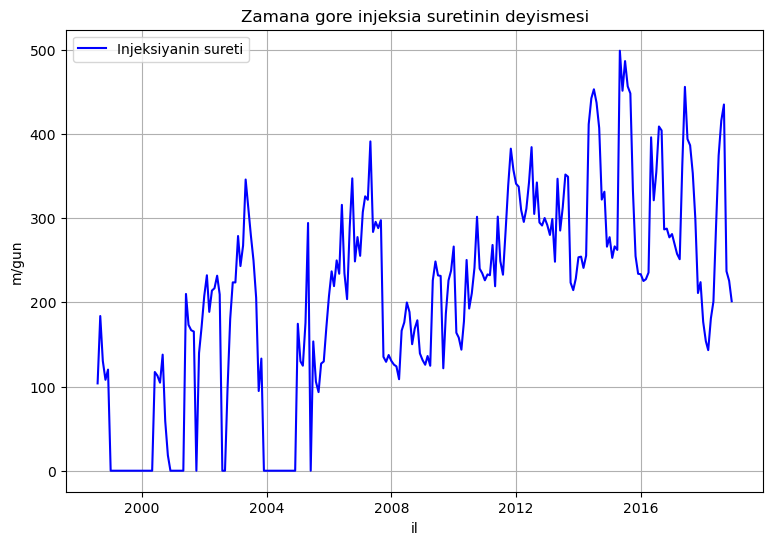

In [30]:
plt.figure(figsize=(9,6))
plt.plot( df['Injectivity rate (m³/day)'],color='blue',label='Injeksiyanin sureti')
plt.title('Zamana gore injeksia suretinin deyismesi')
plt.xlabel('il')
plt.ylabel('m/gun')
plt.legend()
plt.grid(True)
plt.show()

## Sürüşən Orta Qiymət (Rolling Statistics)

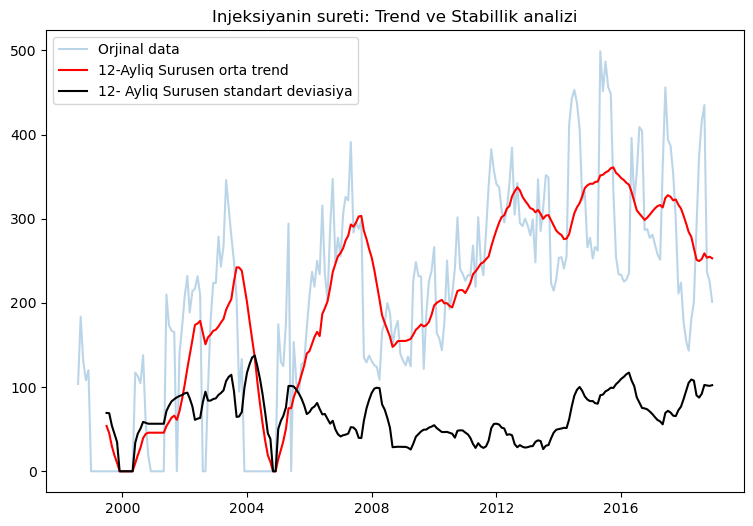

In [40]:
plt.figure(figsize=(9,6))
rolling_mean = df ['Injectivity rate (m³/day)'].rolling(window=12).mean()
rolling_std = df['Injectivity rate (m³/day)'].rolling(window=12).std()

plt.plot(df['Injectivity rate (m³/day)'],alpha=0.3, label="Orjinal data")
plt.plot(rolling_mean, color='red',label ='12-Ayliq Surusen orta trend')
plt.plot(rolling_std, color='black',label='12- Ayliq Surusen standart deviasiya')
plt.title("Injeksiyanin sureti: Trend ve Stabillik analizi")
plt.legend()
plt.show()

## Mövsümi Parçalanma (Seasonal Decomposition)

### Datanın periodikliyini (aylıq olduğu üçün 12) nəzərə alaraq parçalayırıq

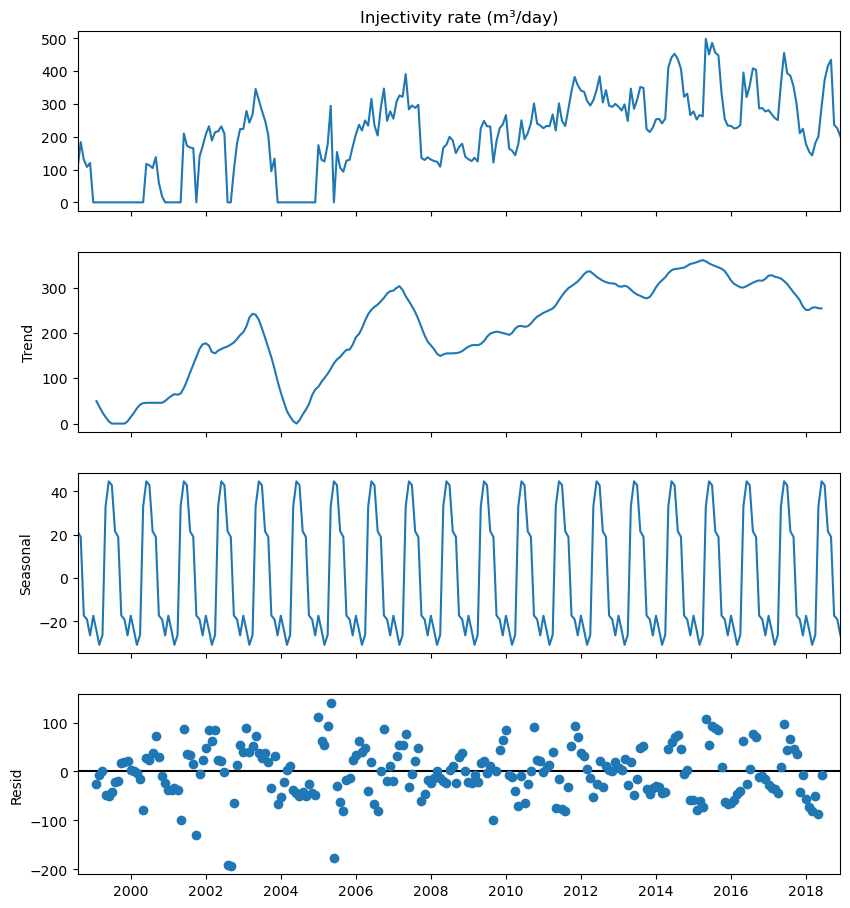

In [49]:
decomposition = seasonal_decompose(df['Injectivity rate (m³/day)'],model= 'additive', period =12)
fig = decomposition.plot()
fig.set_size_inches(9,10)
plt.show()

# Bu hisseye bir de don bax bu

## Korrelyasiya Xəritəsi (Heatmap)

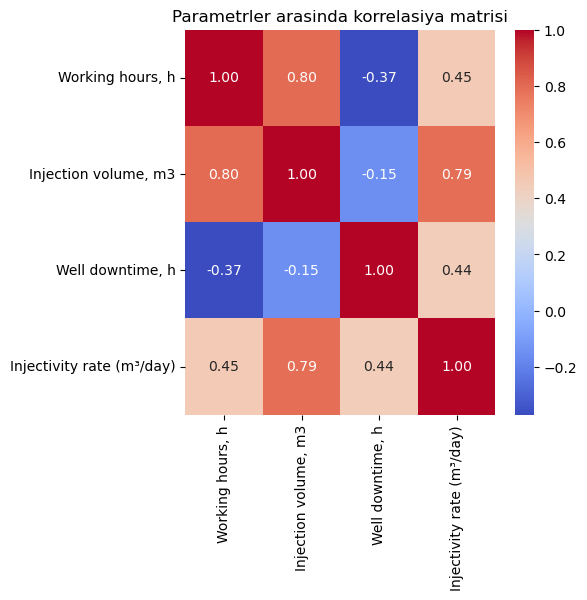

In [51]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), annot=True, cmap ='coolwarm',fmt=".2f")
plt.title("Parametrler arasinda korrelasiya matrisi")
plt.show()

# Step2

## Zaman və Gecikmə (Lag) Göstəricilərinin Yaradılması

In [54]:
df['monrth'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

df['lag1'] = df['Injectivity rate (m³/day)'].shift(1)
df['lag2'] = df['Injectivity rate (m³/day)'].shift(2)
df['lag3'] = df['Injectivity rate (m³/day)'].shift(3)

print ('Zaman ve Lag xusiyyetleri elave edildi')


Zaman ve Lag xusiyyetleri elave edildi


## 2. Sürüşən Statistikalar (Rolling Statistics)

In [55]:
df['rolling_msq_3'] = df['Injectivity rate (m³/day)'].rolling(window=3).std()

df['rolling_msq_3'] = (df['Injectivity rate (m³/day)']**2).rolling(window=3).mean()

print("Rolling statistics 3 ayliq hesablandir")

Rolling statistics 3 ayliq hesablandir


## Əməliyyat Əmsalları və Qarşılıqlı Təsirlər (Interaction Terms)

In [63]:
# Sıfıra bölünmə xətası olmasın diye balaca bir epsilon (1e-6) əlavə edirik
df['inj_per_hour'] = df['Injectivity rate (m³/day)'] / ( df['Working hours, h'] + 1e-6)

total_time = df['Working hours, h'] + df['Well downtime, h']
df['downtime_ratio'] = df['Well downtime, h'] / (total_time + 1e-6)

# Interaction terms: Qarşılıqlı təsir sütunları
df ['vol_times_hours'] = df['Injection volume, m3'] * df['Working hours, h']

df.dropna(inplace=True)

print('Emeliyyat emsallari yaradildi  ve bos setirler temizlendi')
df.head()


Emeliyyat emsallari yaradildi  ve bos setirler temizlendi


,"Working hours, h","Injection volume, m3","Well downtime, h",Injectivity rate (m³/day),monrth,quarter,year,lag1,lag2,lag3,rolling_msq_3,inj_per_hour,downtime_ratio,vol_times_hours
Month/year,,,,,,,,,,,,,,
1998-11-01,720,3240,0,108.0,11,4,1998,130.39,183.77,103.74,20812.321667,0.150000,0.000000,2332800
1998-12-01,240,1201,504,120.1,12,4,1998,108.00,130.39,183.77,14363.187367,0.500417,0.677419,288240
1999-01-01,0,0,0,0.0,1,1,1999,120.10,108.00,130.39,8696.003333,0.000000,0.000000,0
1999-02-01,0,0,0,0.0,2,1,1999,0.00,120.10,108.00,4808.003333,0.000000,0.000000,0
1999-03-01,0,0,0,0.0,3,1,1999,0.00,0.00,120.10,0.000000,0.000000,0.000000,0


# Step 3

# Outlier Detection and Data Cleaning

In [89]:
# 1. Z-score metodu
# 'Injectivity rate (m³/day)' sütunu üzrə kənar meylləri tapırıq

z_scores = np.abs(stats.zscore(df['Injectivity rate (m³/day)']))
df_clean = df[z_scores < 3]

#IQR (Interquartile Range) metodu

Q1 = df_clean['Injectivity rate (m³/day)'].quantile(0.25)
Q3 = df_clean['Injectivity rate (m³/day)'].quantile(0.75)
    
IQR =Q3-Q1

lower_bound = Q1 -1.5* IQR
upper_bound = Q3 + 1.2 * IQR


df_final = df_clean[(df_clean ['Injectivity rate (m³/day)'] >= lower_bound) &
                    (df_clean ['Injectivity rate (m³/day)']<= upper_bound)]

print(f'Orjinal data sayi: {len(df)}')
print(f' Temizlenmis data sayi {len(df_final)}')
print(f'Silinen data sayi: {len(df) - len(df_final)}')

Orjinal data sayi: 245
 Temizlenmis data sayi 243
Silinen data sayi: 2


## Təmizlikdən Sonra Vizuallaşdırma (Boxplot)

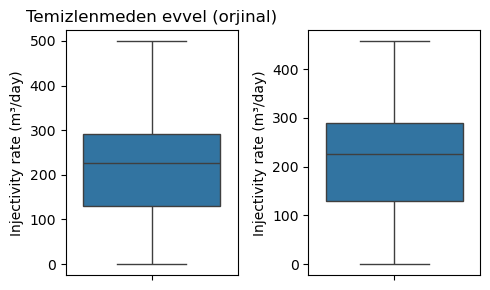

In [92]:
plt.figure(figsize=(5,3))

plt.subplot(1,2,1)
sns.boxplot(y=df['Injectivity rate (m³/day)'])
plt.title('Temizlenmeden evvel (orjinal)')

plt.subplot(1,2,2)
sns.boxplot( y= df_final['Injectivity rate (m³/day)'])

plt.tight_layout()
plt.show()

# Step 4

##  Modellərin Hazırlanması və Validasiya

In [122]:
#  Hədəf (y) və Xüsusiyyətləri (X) müəyyən edirik
x = df_final.drop(columns=['Injectivity rate (m³/day)'])
x = x.select_dtypes(exclude=['datetime64', 'object'])

y = df_final['Injectivity rate (m³/day)']


# Modelləri təyin edirik
lr_model = LinearRegression()
xgb_model = XGBRegressor( n_estimators =100, learning_rate= 0.05, max_depth=5, random_state=42)


def evaluate_model(model,x,y):
    rmses, maes, r2s= [],[],[]

    for train_index,test_index  in tscv.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]

        model.fit(x_train,y_train)
        preds = model.predict(x_test)

        rmses.append(np.sqrt(mean_squared_error(y_test,preds)))
        maes.append(mean_absolute_error(y_test,preds))
        r2s.append(r2_score(y_test,preds))

    return np.mean(rmses), np.mean(maes), np.mean(r2s)
    

# qiymetlendirme

lr_results = evaluate_model(lr_model,x,y)
xgb_results = evaluate_model(xgb_model,x,y)

print(f'Linear Regressiya: {lr_results[0]:.2f}, MAE: {lr_results[1]:.2f}, R2: {lr_results[2]:.2f}')
print(f'XGBoost Reqressiya: {xgb_results[0]:.2f}, MAE: {xgb_results[1]:.2f}, R2: {xgb_results[2]:.2f}')


Linear Regressiya: 37.97, MAE: 23.43, R2: 0.73
XGBoost Reqressiya: 49.07, MAE: 20.72, R2: 0.44


## Proqnozların Vizuallaşdırılması

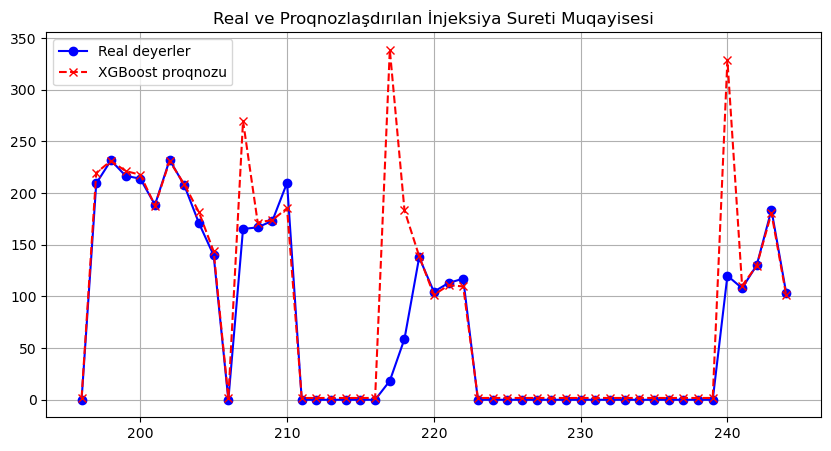

In [126]:
split_index = int(len(x) * 0.8)


x_train, x_test = x.iloc[:split_index], x.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

xgb_model.fit(x_train, y_train)
final_preds = xgb_model.predict(x_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.index,y_test.values,label="Real deyerler", color='blue',marker='o')
plt.plot(y_test.index,final_preds,label='XGBoost proqnozu',color='red',linestyle='--',marker='x')
plt.title("Real ve Proqnozlaşdırılan İnjeksiya Sureti Muqayisesi")
plt.legend()
plt.grid(True)
plt.show()


# Step 5 — Hyperparameter Tuning (Modelin Tənzimlənməsi)

In [144]:
from sklearn.model_selection import RandomizedSearchCV

# Yoxlanılacaq parametrlər
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# x_train və x_test-in kiçik hərflə olduğuna əmin olaraq tənzimləyirik
xgb_tune = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10, 
    scoring='r2',
    cv=tscv, 
    n_jobs=-1
)

xgb_tune.fit(x_train, y_train)
best_xgb = xgb_tune.best_estimator_

print(f"Ən yaxşı parametrlər: {xgb_tune.best_params_}")
tuned_preds = best_xgb.predict(x_test)
print(f"Tuning-dən sonra R2: {r2_score(y_test, tuned_preds):.4f}")

Ən yaxşı parametrlər: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Tuning-dən sonra R2: 0.6280


# Step 6 — Uncertainty Quantification (Qeyri-müəyyənliyin Ölçülməsi)

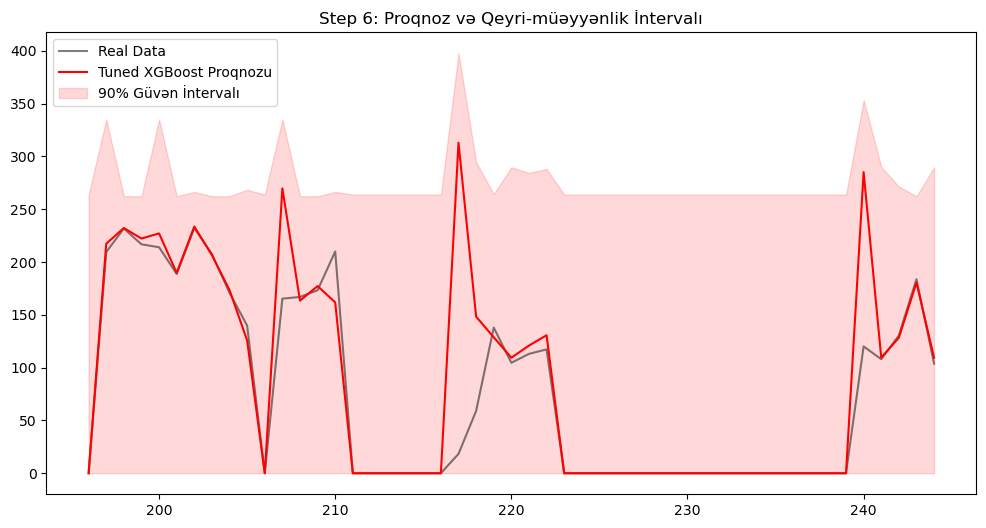

In [145]:
from sklearn.ensemble import GradientBoostingRegressor

# Alt sərhəd (5%)
lower_model = GradientBoostingRegressor(loss='quantile', alpha=0.05, random_state=42)
lower_model.fit(x_train, y_train)
lower_preds = lower_model.predict(x_test)

# Üst sərhəd (95%)
upper_model = GradientBoostingRegressor(loss='quantile', alpha=0.95, random_state=42)
upper_model.fit(x_train, y_train)
upper_preds = upper_model.predict(x_test)

# Vizuallaşdırma
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Real Data', color='black', alpha=0.5)
plt.plot(y_test.index, tuned_preds, label='Tuned XGBoost Proqnozu', color='red')
plt.fill_between(y_test.index, lower_preds, upper_preds, color='red', alpha=0.15, label='90% Güvən İntervalı')

plt.title('Step 6: Proqnoz və Qeyri-müəyyənlik İntervalı')
plt.legend()
plt.show()

# Step 7 — Model Interpretation (Explainable AI)

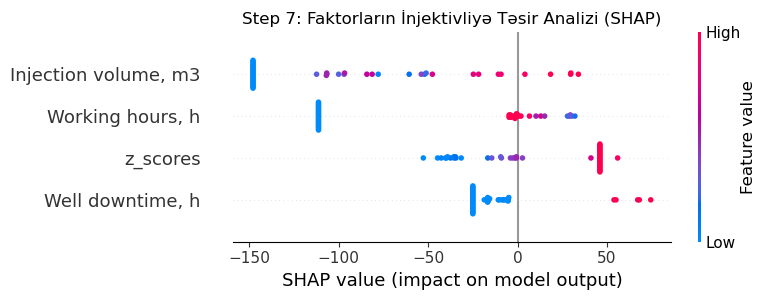

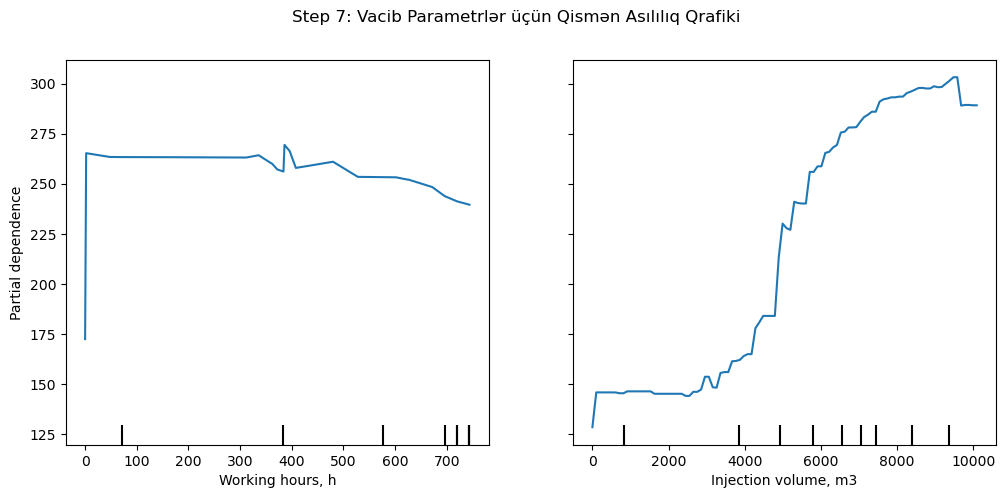

In [147]:
import shap

# SHAP dəyərlərini hesablamaq üçün "Explainer" yaradırıq
# best_xgb (Step 5-də tapdığımız ən yaxşı model) istifadə olunur
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(x_test)

# Summary Plot: Bütün xüsusiyyətlərin proqnoza təsiri
plt.title("Step 7: Faktorların İnjektivliyə Təsir Analizi (SHAP)")
shap.summary_plot(shap_values, x_test)

from sklearn.inspection import PartialDependenceDisplay

# Ən vacib gördüyümüz ilk 2 parametr üçün PDP qrafiki
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(best_xgb, x_train, features=[0, 1], ax=ax)
plt.suptitle('Step 7: Vacib Parametrlər üçün Qismən Asılılıq Qrafiki')
plt.show()

# : Step 8 — Optimization and Scenario Simulation (Optimallaşdırma və Ssenari Simulyasiyası).

In [149]:
# 1. Modelin öyrəndiyi sütunların siyahısını tam dəqiqləşdirək
model_features = x_train.columns.tolist()
print("Modelin gözlədiyi sütunlar:", model_features)

# 2. Ssenari funksiyasını yenidən quraq
def predict_injectivity_fixed(working_hours, injection_vol, downtime):
    # Test dəstindən bir nümunə sətir götürürük
    input_df = x_test.iloc[-1:].copy()
    
    # Dəyərləri yeniləyirik
    input_df['Working hours, h'] = working_hours
    input_df['Injection volume, m3'] = injection_vol
    input_df['Well downtime, h'] = downtime
    
   
    if 'inj_per_hour' in model_features:
        input_df['inj_per_hour'] = injection_vol / (working_hours + 1e-6)
    if 'downtime_ratio' in model_features:
        input_df['downtime_ratio'] = downtime / (working_hours + downtime + 1e-6)
    
    # ƏSAS HİSSƏ: Sütunların ardıcıllığını və sayını modelin öyrəndiyi vaxtla eyni edirik
    input_df = input_df[model_features]
    
    prediction = best_xgb.predict(input_df)[0]
    return prediction

# 3. Yoxlama (Simulyasiya)
# Modelin öyrəndiyi mövcud xüsusiyyətlər əsasında proqnoz alırıq
try:
    current_hours = x_test['Working hours, h'].iloc[-1]
    current_vol = x_test['Injection volume, m3'].iloc[-1]
    current_down = x_test['Well downtime, h'].iloc[-1]
    
    res = predict_injectivity_fixed(current_hours, current_vol, current_down)
    print(f"Simulyasiya uğurla tamamlandı. Nəticə: {res:.2f}")
except Exception as e:
    print(f"Xəta baş verdi: {e}")

Modelin gözlədiyi sütunlar: ['Working hours, h', 'Injection volume, m3', 'Well downtime, h', 'z_scores']
Simulyasiya uğurla tamamlandı. Nəticə: 109.37


# Step 9 — Robustness and Sensitivity Testing

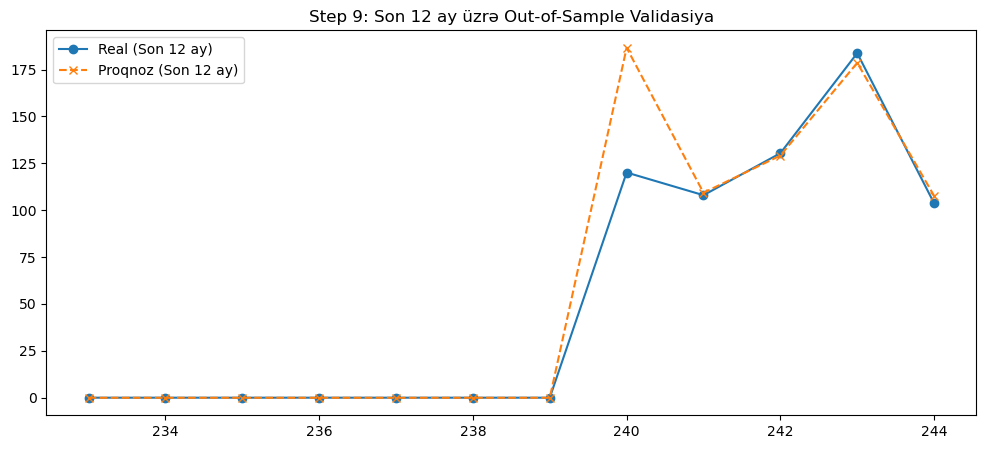

Son il üzrə R2: 0.9154


In [150]:
# Son 12 ayı test üçün ayıraq
train_data = df_final.iloc[:-12]
test_data = df_final.iloc[-12:]

x_train_final = train_data[model_features]
y_train_final = train_data['Injectivity rate (m³/day)']
x_test_final = test_data[model_features]
y_test_final = test_data['Injectivity rate (m³/day)']

# Modeli yenidən öyrədirik
best_xgb.fit(x_train_final, y_train_final)
out_sample_preds = best_xgb.predict(x_test_final)

# Müqayisə qrafiki
plt.figure(figsize=(12, 5))
plt.plot(y_test_final.index, y_test_final.values, label='Real (Son 12 ay)', marker='o')
plt.plot(y_test_final.index, out_sample_preds, label='Proqnoz (Son 12 ay)', marker='x', linestyle='--')
plt.title('Step 9: Son 12 ay üzrə Out-of-Sample Validasiya')
plt.legend()
plt.show()

print(f"Son il üzrə R2: {r2_score(y_test_final, out_sample_preds):.4f}")